<a href="https://colab.research.google.com/github/emilypeek1/YelpSentimentAnalysis/blob/master/YelpSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COLLEGAMENTO GOOGLE DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

INPUT_FOLDER = "/content/drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**IMPORTAZIONE LIBRERIE**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

**IMPORTAZIONE DATASET**

In [ ]:
#NON ESEGUIRE SE IL DATASET IN CSV È GIÀ NEL DRIVE
def load_yelp_orig_data():
  size = 1000000  #one million rows
  review = pd.read_json(INPUT_FOLDER + "yelp_academic_dataset_review.json", lines=True,
                        dtype={'review_id':str,'user_id':str,
                              'business_id':str,'stars':int,
                              'useful':int,'funny':int,'cool':int,
                              'text':str,'date':str},
                        chunksize=size)
  
  # There are multiple chunks to be read
  chunk_list = []
  for chunk_review in review:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'date'], axis=1)
    # Drop rows with missing values
    chunk_review = chunk_review.dropna()
    # Add chunk
    chunk_list.append(chunk_review)
    break
  # After trimming down the review file, concatenate all relevant data back to one dataframe
  df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
  # convert to csv
  csv_name = "yelp_reviews.csv"
  df.to_csv(INPUT_FOLDER + csv_name, index=False)

load_yelp_orig_data()

In [3]:
df = pd.read_csv(INPUT_FOLDER + 'yelp_reviews.csv')

In [ ]:
#This code can be used to check type inconsistencies

#weird = (top_data_df.applymap(type) != top_data_df.iloc[0].apply(type)).any(axis=1)
#print(top_data_df[weird])
#top_data_df.stars = top_data_df.stars.astype('int')
#print(top_data_df.iloc[1048575, 0].dtype)
#print(top_data_df.iloc[1048576, 0] > 0)

#top_data_df.stars = top_data_df.stars.astype(np.int64)
#print(top_data_df.iloc[1048576, 0].dtype)

**AGGIUNTA COLONNA SENTIMENT**

Number of rows per star rating:
5    449091
4    210363
1    156690
3    104973
2     78883
Name: stars, dtype: int64


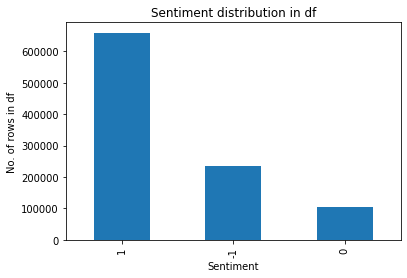

In [4]:
print("Number of rows per star rating:")
print(df['stars'].value_counts())

# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['stars']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

**BILANCIAMENTO DATASET**

In [5]:
# Function to retrieve top few number of each category
def get_top_data(top_n):
    df_positive = df[df['sentiment'] == 1].head(top_n)
    df_negative = df[df['sentiment'] == -1].head(top_n)
    df_neutral = df[df['sentiment'] == 0].head(top_n)
    df_balanced = pd.concat([df_positive, df_negative, df_neutral])
    return df_balanced

# Function call to get the top 100.000 from each sentiment
df_balanced = get_top_data(100000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(df_balanced['sentiment'].value_counts())

After segregating and taking equal number of rows for each sentiment:
-1    100000
 1    100000
 0    100000
Name: sentiment, dtype: int64


**TOKENIZZAZIONE**

In [6]:
# Tokenize the text column to get the new column 'tokenized_text'
df_balanced['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df_balanced['text']] 
print(df_balanced['tokenized_text'].head(5))

2    [love, deagan, do, really, do, the, atmosphere...
4    [oh, happy, day, finally, have, canes, near, m...
5    [this, is, definitely, my, favorite, fast, foo...
6    [really, good, place, with, simple, decor, ama...
7    [awesome, office, and, staff, very, profession...
Name: tokenized_text, dtype: object


**STEMMING**

In [7]:
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
df_balanced['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df_balanced['tokenized_text'] ]
print(df_balanced['stemmed_tokens'].head(5))

2    [love, deagan, do, realli, do, the, atmospher,...
4    [oh, happi, dai, final, have, cane, near, my, ...
5    [thi, is, definit, my, favorit, fast, food, su...
6    [realli, good, place, with, simpl, decor, amaz...
7    [awesom, offic, and, staff, veri, profession, ...
Name: stemmed_tokens, dtype: object


**TRAINING MODELLO WORD2VEC** 

Vengono generati tre file per il modello:


1.   word2vec_model
2.   word2vec_model.trainables.syn1neg
3.   word2vec_model.wv.vectors



In [8]:
#NON ESEGUIRE SE IL MODELLO È GIÀ NEL DRIVE
size = 300    #dim of word vectors
window = 3    #context window
min_count = 1 #ignore words with lower frequency
workers = 3   #training threads
sg = 1        #Skip-gram model

word2vec_model_file = INPUT_FOLDER + 'word2vec_model'
start_time = time.time()
# train only on the stemmed tokens
stemmed_tokens = pd.Series(df_balanced['stemmed_tokens']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 808.2884511947632


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**CARICAMENTO MODELLO WORD2VEC**

In [9]:
# Load the model from the model file
w2v_model = Word2Vec.load(INPUT_FOLDER + 'word2vec_model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**DIVISIONE DATASET IN TRAINING E TESTING DATASET**

In [10]:
# Train Test Split Function
def split_train_test(df_balanced, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df_balanced[['stars', 'stemmed_tokens']], 
                                                        df_balanced['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df_balanced)

**GENERAZIONE TRAINING DATASET WORD2VEC**

In [11]:
#NON ESEGUIRE SE TRAIN_REVIEW_WORD2VEC È GIÀ NEL DRIVE
# Store the vectors for train data in following file
word2vec_filename = INPUT_FOLDER + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        #average over all the vectors of words in a sentence
        model_vector = (np.mean([w2v_model[token] for token in row['stemmed_tokens']], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(300))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(300)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**CARICAMENTO TRAINING DATASET WORD2VEC**

In [12]:
# Load from the filename
word2vec_df = pd.read_csv(INPUT_FOLDER + 'train_review_word2vec.csv')


In [81]:
#print(word2vec_df.iloc[210000, 299])
print(Y_train['sentiment'][209999])
X_train.columns

0


Index(['index', 'stars', 'stemmed_tokens'], dtype='object')

**TRAINING CLASSIFICATORI**

In [13]:
#Initialize the model
nb_classifier = GaussianNB()

start_time = time.time()
# Fit the model
nb_classifier.fit(word2vec_df, Y_train['sentiment'])
print("Time taken to fit the RF model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the RF model with word2vec vectors: 1.4205007553100586


In [14]:
#Initialize the model
rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=15)

start_time = time.time()
# Fit the model
rf_classifier.fit(word2vec_df, Y_train['sentiment'])
print("Time taken to fit the RF model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the RF model with word2vec vectors: 9.772306442260742


In [16]:
#Initialize the model
svc_classifier = LinearSVC()

start_time = time.time()
# Fit the model
svc_classifier.fit(word2vec_df, Y_train['sentiment'])
print("Time taken to fit the SVC model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the SVC model with word2vec vectors: 293.67576146125793


In [ ]:
# neural network

**TESTING CLASSIFICATORI**

In [100]:
#This will be the new X_test
test_word2vec = []
count = 0;
for index, row in X_test.iterrows():
    model_vector = np.mean([w2v_model[token] for token in row['stemmed_tokens']], axis=0)
    if isinstance(model_vector, np.ndarray):
      test_word2vec.append(model_vector)
    else:
      count = count + 1
      test_word2vec.append(np.array([0 for i in range(300)]))
print(count)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5


In [101]:
test_word2vec[2600]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [102]:
test_predictions_nb = nb_classifier.predict(test_word2vec)
test_predictions_rf = rf_classifier.predict(test_word2vec)
test_predictions_svc = svc_classifier.predict(test_word2vec)
print(classification_report(Y_test['sentiment'],test_predictions_nb))
print(classification_report(Y_test['sentiment'],test_predictions_rf))
print(classification_report(Y_test['sentiment'],test_predictions_svc))

              precision    recall  f1-score   support

          -1       0.55      0.68      0.61     30174
           0       0.49      0.52      0.50     29921
           1       0.62      0.42      0.50     29905

    accuracy                           0.54     90000
   macro avg       0.55      0.54      0.54     90000
weighted avg       0.55      0.54      0.54     90000

              precision    recall  f1-score   support

          -1       0.59      0.65      0.62     30174
           0       0.50      0.47      0.48     29921
           1       0.59      0.57      0.58     29905

    accuracy                           0.56     90000
   macro avg       0.56      0.56      0.56     90000
weighted avg       0.56      0.56      0.56     90000

              precision    recall  f1-score   support

          -1       0.76      0.80      0.78     30174
           0       0.66      0.63      0.65     29921
           1       0.81      0.80      0.80     29905

    accuracy        

In [43]:
w2v_model.wv.most_similar("cat")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('kitten', 0.6020901203155518),
 ('dog', 0.5917652249336243),
 ('pup', 0.5859158039093018),
 ('pet', 0.578101634979248),
 ('pug', 0.5507873892784119),
 ('felin', 0.532281756401062),
 ('anim', 0.5285110473632812),
 ('neuter', 0.5258612632751465),
 ('pomeranian', 0.5222690105438232),
 ('kitti', 0.5086629390716553)]